In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suicidal-mental-health-dataset/mental-health.csv


In [2]:
import tensorflow as tf
import keras
from keras import layers, optimizers

from keras_hub.tokenizers import WordPieceTokenizer, compute_word_piece_vocabulary

from keras_hub.layers import TokenAndPositionEmbedding, FNetEncoder

import keras_tuner as kt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/kaggle/input/suicidal-mental-health-dataset/mental-health.csv')

df['label'] = df['label'].str.replace('SuicideWatch', 'suicidal')
df['label'] = df['label'].str.lower()

binarized = []
for label in df['label']:
    if label == 'suicidal':
        binarized.append(1)
    else:
        binarized.append(0)

binarized = pd.Series(binarized, name='label')
df = df.drop('label', axis=1)
df = pd.concat([df, binarized], axis=1)

In [4]:
train_df, other = train_test_split(
    df,
    test_size = 0.16,
    random_state = 9730,
    shuffle = True,
    stratify = df['label'],
)

val_df, test_df = train_test_split(
    other,
    test_size = 0.5,
    random_state = 9730,
    shuffle = True,
    stratify = other['label'],
)

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['text'].values, train_df['label'].values)
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['label'].values)
)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['label'].values)
)

In [6]:
# convert the text to lowercase
train_dataset = train_dataset.map(lambda text, label: (tf.strings.lower(text), label))
val_dataset = val_dataset.map(lambda text, label: (tf.strings.lower(text), label))
test_dataset = test_dataset.map(lambda text, label: (tf.strings.lower(text), label))

In [7]:
BATCH_SIZE = 64
MAX_SEQLEN = 512
auto = tf.data.AUTOTUNE

In [8]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(auto)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(auto)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(auto)

In [9]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f"{text_batch.numpy()[i]}\n{label_batch.numpy()[i]}\n")

b"i know it sounds stupid, almost everyone outlives their grandparents. but he is so important to me. he has been involved in my life so much. much more than my parents even. hes like a parent and a best friend. my homelife is very poor. my mom is verbally abusive and my father works almost all of the time. my grandparent's house was the only place i could go to when no one else wanted me. it is the only accepting place i know. i love my grandfather more than anyone could imagine. he is violently ill with covid. we aren;t sure if he will make it. he has been getting progeresivlet worse. i have not seen him in two weeks. i miss and and i want to make sure he is ok. i am sorry pop. i cannot live without you... my grandfather is very ill and i do not know if i can live without him."
1

b'i am a normal guy, where i live finding a job is super hard, and the ones that hire will not hire me, and i try to do my best at streaming or finding online jobs.even when i spent most of my day trying to

In [10]:
#Calculate Vocabulary Size
vocabulary = set()
train_df['text'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

78350


In [11]:
reserved_tokens = ["[PAD]", "[UNK]"]

In [12]:
def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1024).prefetch(2),
        vocabulary_size=vocabulary_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [13]:
vocab = train_word_piece(train_dataset, vocabulary_size, reserved_tokens)

In [14]:
print(f'Tokens: {vocab[24:101]}')

Tokens: ['7', '8', '9', ':', ';', '=', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', 'to', 'and', 'my', 'the', 'not', 'am', 'it', 'is', 'of', 'have', 'me', 'do', 'that', 'in', 'but', 'just', 'for', 'this', 'so', 'was', 'with', 'like', 'be', 'want', 'feel', 'you', 'all', 'on', 'life', 'cannot', 'or', 'myself', 'know']


In [15]:
tokenizer = WordPieceTokenizer(
    vocabulary = vocab,
    lowercase = False,
    sequence_length = MAX_SEQLEN,
)

In [16]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b"i know it sounds stupid, almost everyone outlives their grandparents. but he is so important to me. he has been involved in my life so much. much more than my parents even. hes like a parent and a best friend. my homelife is very poor. my mom is verbally abusive and my father works almost all of the time. my grandparent's house was the only place i could go to when no one else wanted me. it is the only accepting place i know. i love my grandfather more than anyone could imagine. he is violently ill with covid. we aren;t sure if he will make it. he has been getting progeresivlet worse. i have not seen him in two weeks. i miss and and i want to make sure he is ok. i am sorry pop. i cannot live without you... my grandfather is very ill and i do not know if i can live without him.", shape=(), dtype=string)
Tokens:  tf.Tensor(
[  46  100   74  861  391   13  325  199  111  798 6360  248 2289   15
   82  136   75   86  827   68   78   15  136  149  113 1973   81   70
 

In [17]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(BATCH_SIZE * 8).prefetch(16).cache()

In [18]:
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [19]:
EMBED_DIM = 128
INTERMEDIATE_DIM = 4 * EMBED_DIM

In [20]:
def FentTweaker():
    input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")
    x = TokenAndPositionEmbedding(
        vocabulary_size=vocabulary_size,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero=True,
    )(input_ids)
    
    x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(0.20)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(input_ids, outputs, name="FentTweaker9730")
    model.compile(
        optimizer = optimizers.Adam(
            learning_rate = 1e-4
        ),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )
    return model

In [21]:
FentTweaker9730 = FentTweaker()

In [22]:
FentTweaker9730.summary()

Model: "FentTweaker9730"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 128)           │      10,094,336 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder (FNetEncoder)          │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_1 (FNetEncoder)        │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_2 (FNetEncoder)        │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,491,137 (40.02 MB)

 Trainable params: 10,491,137 (40.02 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
reduceLR = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.0973,
    patience = 3,
    verbose = 1,
    mode = "auto",
    min_delta = 1e-4,
    cooldown = 0,
    min_lr = 0,
)

In [25]:
earlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0.001,
    patience = 4,
    verbose = 1,
    mode = "auto",
    restore_best_weights = True,
    start_from_epoch = 11,
)

In [26]:
history = FentTweaker9730.fit(
    train_dataset,
    epochs=25, 
    validation_data=val_dataset,
    callbacks=[earlyStop, reduceLR]
)

Epoch 1/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.5166 - loss: 0.6966 - val_accuracy: 0.5862 - val_loss: 0.6819 - learning_rate: 1.0000e-04
Epoch 2/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.5584 - loss: 0.6834 - val_accuracy: 0.6096 - val_loss: 0.6689 - learning_rate: 1.0000e-04
Epoch 3/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.6081 - loss: 0.6601 - val_accuracy: 0.6771 - val_loss: 0.6083 - learning_rate: 1.0000e-04
Epoch 4/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.6969 - loss: 0.5848 - val_accuracy: 0.7213 - val_loss: 0.5609 - learning_rate: 1.0000e-04
Epoch 5/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.7599 - loss: 0.5012 - val_accuracy: 0.7317 - val_loss: 0.5445 - learning_rate: 1.0000e-04
Epoch 6/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8056 - loss: 0.4336 - val_accuracy: 0.7287 - val_loss: 0.5609 - learning_rate: 1.0000e-04
Epoch 7/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/ste

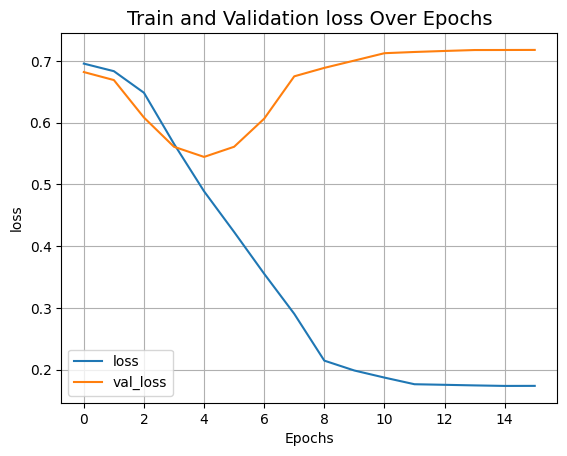

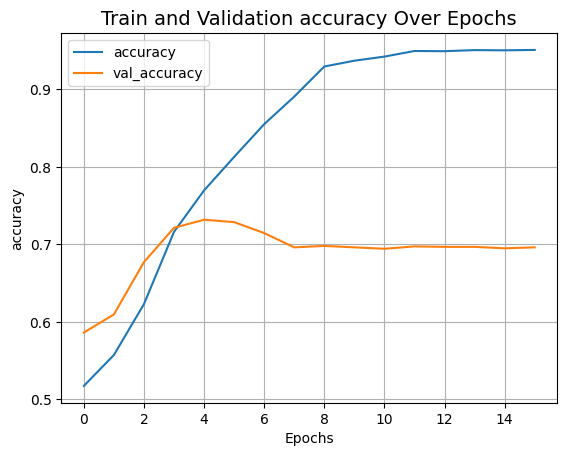

In [27]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [29]:
FentTweaker9730.evaluate(test_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7033 - loss: 0.6939


[0.712049663066864, 0.699386477470398]